In [1]:
from typing import Dict, List, Iterable

import pandas as pd
from pathlib import Path
import pickle
import re
from collections import defaultdict
import warnings
import copy
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

warnings.simplefilter(action='ignore', category=UserWarning)

import re
from tqdm.notebook import tqdm

In [2]:
experiments_dir = Path('../experiments')
experiments = [x.name for x in experiments_dir.iterdir()]
experiments = [experiment for experiment in experiments if (experiments_dir / experiment / 'done').exists()]
experiments

['experiment_exp_sup_v1_True_v2_True_v4_scenario_no_vaccine',
 'experiment_exp_sup_v1_False_optimizer_adam',
 'experiment_exp_ad_v1_True_v2_6',
 'experiment_exp_sup_v1_False_v2_True_v4_scenario_no_vaccine',
 'experiment_exp_sup_v1_False_optimizer_sgd_fedprox',
 'experiment_exp_sup_v1_True_v2_False_1800s_2d',
 'experiment_exp_sup_v1_False_v2_False',
 'experiment_exp_sup_v1_True_v2_True_v4_scenario',
 'experiment_exp_sup_v1_True_v2_False_1800s_3d_scenario',
 'experiment_exp_sup_v1_False_v2_False_v4_scenario',
 'experiment_exp_sup_v1_False_mu_01',
 'experiment_exp_sup_v1_True_1800s_2d',
 'experiment_exp_sup_v1_True_v2_True_1800s_scenario',
 'experiment_exp_sup_v1_False_no_vaccine',
 'experiment_exp_sup_v1_True_6400s',
 'experiment_exp_sup_v1_False_v3_False',
 'experiment_exp_sup_v1_True_v2_False_v4_scenario',
 'experiment_exp_ad_v1_True_v2_3',
 'experiment_exp_sup_v1_True_1800s_vaccine_only_half',
 'experiment_exp_ad_v1_False_v2_10',
 'experiment_exp_sup_v1_False_mu_1',
 'experiment_exp_s

In [3]:
exps = ['experiment_exp_sup_v1_True_v2_True_1800s_scenario', 'experiment_exp_sup_v1_True_v2_True_1800s_2d_scenario', 'experiment_exp_sup_v1_True_v2_True_1800s_3d_scenario'] #[exp for exp in experiments if re.match(r'experiment_exp_sup_v1_True_[0-9]+s.*', exp)]
exps

['experiment_exp_sup_v1_True_v2_True_1800s_scenario',
 'experiment_exp_sup_v1_True_v2_True_1800s_2d_scenario',
 'experiment_exp_sup_v1_True_v2_True_1800s_3d_scenario']

In [4]:
class ExperimentResult:
    def __init__(self, experiment_path):
        self.name = experiment_path.name
        self.path = experiment_path / 'results'

        self.n_days = max(int(x.name[3]) for x in (self.path / '00').iterdir())

        self.run_results = self._load_run_results()
        self.days = self._agg_runs()

        self.fed_df = self._df(lambda x: x.fed)
        self.cent_df = self._df(lambda x: x.cent)
        self.local_df = self._df(lambda x: x.local)

        self.fed_runs = [self._run_df(day, lambda x: x.fed) for day in range(self.n_days)]
        self.cent_runs = [self._run_df(day, lambda x: x.cent) for day in range(self.n_days)]
        self.local_runs = [self._run_df(day, lambda x: x.local) for day in range(self.n_days)]

    def _load_run_results(self) -> List[List['DayResults']]:
        run_results = []
        for run_path in sorted(self.path.iterdir()):
            run_results.append([DayResults(run_path, day) for day in range(1, self.n_days + 1)])
        return run_results

    def _agg_runs(self) -> List['DayResults']:
        days = []
        for day in range(self.n_days):
            days.append(DayResults.agg([run_result[day] for run_result in self.run_results]))

        return days

    def _df(self, get_fun):
        df = pd.concat([get_fun(day).data for day in self.days])
        df.index = range(1, len(self.days) + 1)
        return df

    def _run_df(self, day, get_fun):
        df = pd.concat([get_fun(run[day]).data for run in self.run_results])
        df.index = range(1, len(self.run_results) + 1)
        return df



class DayResults:
    def __init__(self, experiment_path, day):
        self.day = day
        res_file = list(experiment_path.iterdir())[0].name
        seed = re.match(rf'day[0-9]_([0-9]+)_[a-z]+_results.pckl', res_file).groups()[0]

        self.fed_complete = CompleteResult.from_fed(experiment_path / f'day{day}_{seed}_federated_results.pckl')
        self.cent_complete = CompleteResult.from_centralized(
            experiment_path / f'day{day}_{seed}_centralized_results.pckl')
        self.local_complete = CompleteResult.from_fed(experiment_path / f'day{day}_{seed}_local_results.pckl',
                                                      local=True)

        self.fed = Results.from_complete(self.fed_complete)
        self.cent = Results.from_complete(self.cent_complete)
        self.local = Results.from_complete(self.local_complete)

    @staticmethod
    def agg(results):
        new = copy.deepcopy(results[0])
        new.fed_complete = None
        new.cent_complete = None
        new.local_complete = None

        new.fed = Results.agg([res.fed for res in results])
        new.cent = Results.agg([res.cent for res in results])
        new.local = Results.agg([res.local for res in results])

        return new


class CompleteResult(pd.DataFrame):
    def __init__(self, data, best_round=None, clients=None):
        super().__init__(data)
        if 'fn' not in self.columns and 'ad_fn' in self.columns:
            self['fn'] = self['ad_fn']
        self.best_round = best_round if best_round is not None else self.shape[0] - 1
        self.clients = clients if clients else {}

    @staticmethod
    def from_fed(results_path: Path, local=False):
        with results_path.open('rb') as f:
            results = pickle.load(f)

        client_results = defaultdict(dict)
        client_res_pattern = re.compile('(.*)_([0-9]{2})')
        result = {}
        for name, metric in results.metrics_distributed.items():
            if match := re.match(client_res_pattern, name):
                groups = match.groups()
                client_id = int(groups[1])
                client_results[client_id][groups[0]] = CompleteResult.metric_to_series(metric)
            else:
                result[name] = CompleteResult.metric_to_series(metric)

        if hasattr(results, 'val_losses_distributed'):
            result['val_loss'] = CompleteResult.metric_to_series(results.val_losses_distributed)
        else:
            result['val_loss'] = CompleteResult.metric_to_series(results.metrics_distributed['val_loss'])

        last_round = len(result['val_loss']) - 1
        best_round = result['val_loss'].argmin() if not local else last_round

        client_results = {client_id: CompleteResult(res, best_round) for client_id, res in client_results.items()}

        return CompleteResult(result, best_round, client_results)

    @staticmethod
    def from_centralized(results_path: Path):
        with results_path.open('rb') as f:
            results = pickle.load(f)

        res_df = pd.DataFrame(results)

        best_round = res_df['val_loss'].argmin()
        return CompleteResult(res_df, best_round)

    @property
    def best(self):
        return self.iloc[[self.best_round]]

    @staticmethod
    def metric_to_series(metric):
        return pd.Series(value for i, value in metric if i > 0)


class Results:
    def __init__(self, data: pd.DataFrame, clients: Dict[int, 'Results'] = None):
        self.data = data.reindex()
        if 'f1' not in data.columns:
            self.data = self.compute_metrics(self.data)
        self.clients = clients if clients is not None else {}

    @staticmethod
    def from_complete(results: CompleteResult):
        best = results.best
        clients = {client_id: Results(res.best) for client_id, res in results.clients.items()}
        return Results(best, clients)

    def compute_metrics(self, df):
        conf_mat_names = 'tp', 'fp', 'tn', 'fn'

        if 'cls_tp' in df.columns:
            tp, fp, tn, fn = [df[f'cls_{x}'] for x in conf_mat_names]
            if any(col.startswith('global_') for col in df.columns):
                tp, fp, tn, fn = [df[f'global_cls_{x}'] for x in conf_mat_names]
        else:
            tp, fp, tn, fn = [df[f'{x}'] for x in conf_mat_names]
            if any(col.startswith('global_') for col in df.columns):
                tp, fp, tn, fn = [df[f'global_{x}'] for x in conf_mat_names]

        df['f1'] = tp / (tp + 0.5 * (fp + fn))
        df['tpr'] = tp / (tp + fn)
        df['fpr'] = fp / (fp + tn)
        df['tnr'] = tn / (tn + fp)
        df['fnr'] = fn / (fn + tp)
        df['precision'] = tp / (tp + fp)
        df['f0.5'] = (1 + 0.5**2) * (df['precision'] * df['tpr']) / ((0.5**2 * df['precision']) + df['tpr'])
        df['f2'] = (1 + 2**2) * (df['precision'] * df['tpr']) / ((2**2 * df['precision']) + df['tpr'])
        df['acc'] = (tp + tn) / (tp + tn + fp + fn)

        return df

    def __repr__(self):
        return self.data.__repr__()

    def __str__(self):
        return self.data.__str__()

    @staticmethod
    def agg(results: List['Results']):
        df = pd.concat(res.data for res in results).reindex()
        integer_cols = df.dtypes.transform(pd.api.types.is_integer_dtype)
        new_df = pd.DataFrame({0: df.loc[:, integer_cols].sum(axis=0)}).T

        for col in df.columns[~integer_cols]:
            new_df[f'{col}_mean'] = df[col].mean()
            new_df[f'{col}_std'] = df[col].std()

        clients = {client_id: Results.agg([res.clients[client_id] for res in results])
                   for client_id in results[0].clients}

        return Results(new_df, clients)



In [5]:
#exps = experiments #{'experiment_exp_sup_v1_False_1800', 'experiment_exp_sup_v1_False_3600', 'experiment_exp_sup_v1_False_6400'}
results = {exp: ExperimentResult(experiments_dir / exp) for exp in tqdm(experiments) if exp in exps}

  0%|          | 0/35 [00:00<?, ?it/s]

In [6]:
results.keys()

dict_keys(['experiment_exp_sup_v1_True_v2_True_1800s_scenario', 'experiment_exp_sup_v1_True_v2_True_1800s_3d_scenario', 'experiment_exp_sup_v1_True_v2_True_1800s_2d_scenario'])

In [57]:
# results_path = experiments_dir / 'experiment_exp_sup_v1_False_v2_True_v4_scenario_no_vaccine/results/00/day1_637759973_centralized_results.pckl'
# results_path.parent.exists()
# results_path = experiments_dir / 'experiment_exp_ad_v1_True_v2_3/results/00/day1_782526238_centralized_results.pckl'
# with results_path.open('rb') as f:
#     results = pickle.load(f)
# #res2_path = experiments_dir / 'experiment_default' / 'results' / '00' / 'day2_848924392_federated_results.pckl'
#
# complete = CompleteResult.from_centralized(results_path)
# res = Results.from_complete(complete)

#complete_2 = CompleteResult.from_fed(res2_path)
#res_2 = Results.from_complete(complete_2)
#df = pd.concat([res.data, res_2.data]).reindex()
#integer_cols = df.dtypes.transform(pd.api.types.is_integer_dtype)
#new_df = df.loc[:, integer_cols].sum()

# for col in df.columns[~integer_cols]:
#     new_df[f'{col}_mean'] = df[col].mean()
#     new_df[f'{col}_std'] = df[col].std()
# new_df

# res

True

In [7]:
def parse_experiment_name(exp_name):
    exp_name = exp_name.lstrip('experiment_exp_')
    type, *exp_name = exp_name.split('_')
    name = ''

    ad_map = {
        'v1': {
            'True': '; using previous day model',
            'False': '; training from scratch each day'
        },
        'v2': {
            '10': '; training on 10 clients',
            '6': '; training on 6 clients',
            '3': '; training on 3 clients',
        }
    }
    sup_map = {
        'v1': {
            'False': 'MultiHead Model',
            'True': 'Classifier Model',
            'default': 'False'
        },
        'v2': {
            'True': '; using previous day model',
            'False': '; training from scratch each day',
            'default': 'True'
        },
        'v3': {
            'True': ';\ntraining in all clients',
            'False': ';\ntraining only in clients with malware',
            'default': 'True'
        },
        'v4': {
            'complete': '; using complete malware dataset',
            'scenario': '; using custom malware scenario',
            'default': 'complete'
        }
    }

    if type == 'sup':
        name += "Supervised "
        _vars = dict(zip(exp_name[::2], exp_name[1::2]))
        vars = []
        for var_name in sorted(sup_map.keys()):
            if var_name in _vars:
                vars.append((var_name, _vars[var_name]))
            else:
                vars.append((var_name, sup_map[var_name]['default']))

        for var_name, var_value in vars:
            name += sup_map[var_name][var_value]
    if type == 'ad':
        name += "Anomaly detection "
        vars = list(zip(exp_name[::2], exp_name[1::2]))
        for var_name, var_value in vars:
            name += ad_map[var_name][var_value]

    return name

In [8]:
ylims = [[1.0019581797381467, 0.8444431159894483],
 [1.05, -0.05],
 [1.05, -0.05],
 [0.13763624584261341, -0.0030666933376325336]]

In [12]:
def _plot_result(res, axs, metric, metric_name, y_ticks=True):
    labels = []

    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    add_label(axs.violinplot(dataset=[res.cent_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                             positions=[2.5 * (i) - 0.5 for i in range(4)]), 'Centralized')
    add_label(axs.violinplot(dataset=[res.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                             positions=[2.5 * i for i in range(4)]), 'Federated')
    add_label(axs.violinplot(dataset=[res.local_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                             positions=[2.5 * i + 0.5 for i in range(4)]), 'Local')
    legend_loc = 4 if metric != 'fpr' else 1
    axs.legend(*zip(*labels), loc=legend_loc, fontsize=12)
    axs.set_xticks([2.5 * i for i in range(4)], [f'Day {i + 2}' for i in range(4)], fontsize=14)
    axs.tick_params(labelsize=14)
    if y_ticks:
        axs.set_ylabel(f'{metric_name} %', fontsize=18)
    # else:
    #     axs.set_yticks([])
    #axs.set_title(metric_name)

    return


def plot_result(res, title, ylims=ylims, name=None, y_ticks=True):
    fig, axs = plt.subplots(4, 1, figsize=(5, 20))
    fig.set_tight_layout(False)
    _plot_result(res, axs[0], 'acc', 'Accuracy', y_ticks)
    _plot_result(res, axs[1], 'f1', 'F1', y_ticks)
    _plot_result(res, axs[2], 'tpr', 'TPR', y_ticks)
    _plot_result(res, axs[3], 'fpr', 'FPR', y_ticks)

    # new_ylims = []
    # for ax, (y_max, y_min) in zip(axs, ylims):
    #     ax_min, ax_max = ax.get_ylim()
    #     new_ylims.append([max(y_max, ax_max), min(y_min, ax_min)])
    # ylims = new_ylims
    for ax, (y_max, y_min) in zip(axs, ylims):
        ax.set_ylim((y_min, y_max))

    fig.set_tight_layout(True)
    fig.suptitle(title)
    if name is not None:
        plt.savefig(f'{name}.pdf')
    plt.show()




In [13]:
y_lims = [[100.1, 91], [105, 0], [105, 25], [5.5, -0.1]]
plot_result(results['experiment_exp_sup_v1_True_1800s'], '', y_lims, 'res_base_1800s', False)
plot_result(results['experiment_exp_sup_v1_True_1800s_2d'], '', y_lims, 'res_base_3600s', False)
plot_result(results['experiment_exp_sup_v1_True_1800s_3d'], '', y_lims, 'res_base_6400s', False)

KeyError: 'experiment_exp_sup_v1_True_1800s'

ValueError: List of violinplot statistics and `positions` values must have the same length

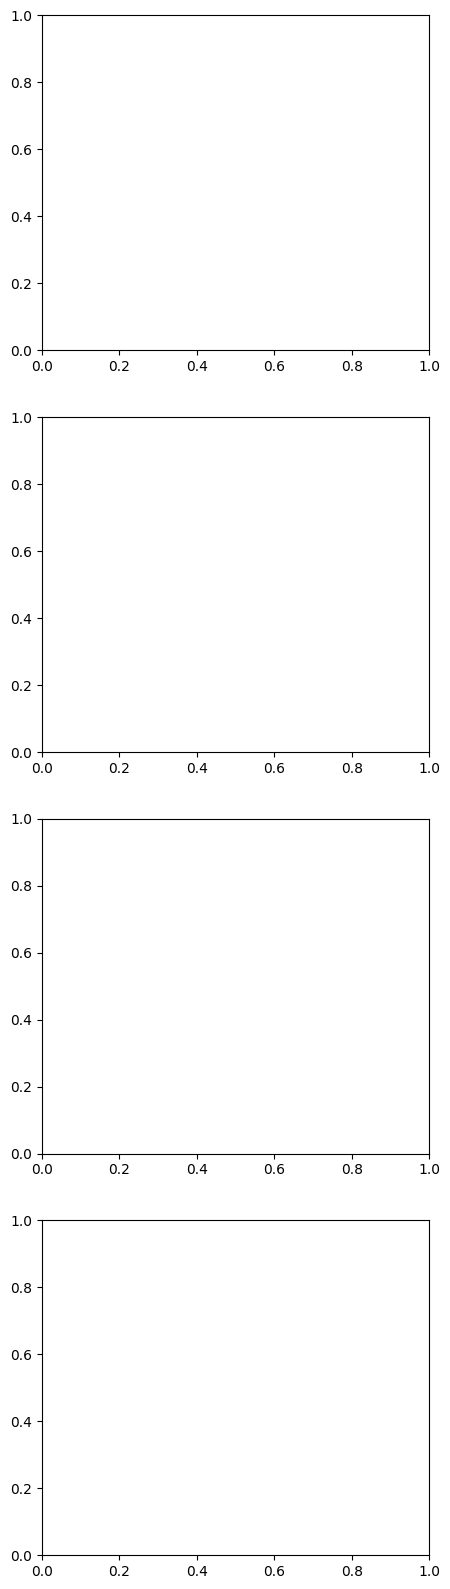

In [25]:
#for res_name, res in results.items():
#    plot_result(res, f'{res_name}\n{parse_experiment_name(res_name)}')

In [72]:
list(results.keys())

['experiment_exp_ad_v1_True_v2_3',
 'experiment_exp_sup_v1_False_v3_False',
 'experiment_exp_sup_v1_False_optimizer_sgd_fedprox',
 'experiment_exp_sup_v1_False_v2_False_v4_scenario',
 'experiment_exp_ad_v1_False_v2_10',
 'experiment_exp_sup_v1_False_optimizer_adam',
 'experiment_exp_sup_v1_False',
 'experiment_exp_sup_v1_True_v2_False_v4_scenario',
 'experiment_exp_sup_v1_False_v2_True_v4_scenario',
 'experiment_exp_sup_v1_True_v2_False',
 'experiment_exp_sup_v1_True_v2_True_v4_scenario',
 'experiment_exp_ad_v1_True_v2_10',
 'experiment_exp_ad_v1_True_v2_6',
 'experiment_exp_sup_v1_True',
 'experiment_exp_sup_v1_True_v3_False',
 'experiment_exp_sup_v1_False_v2_False']

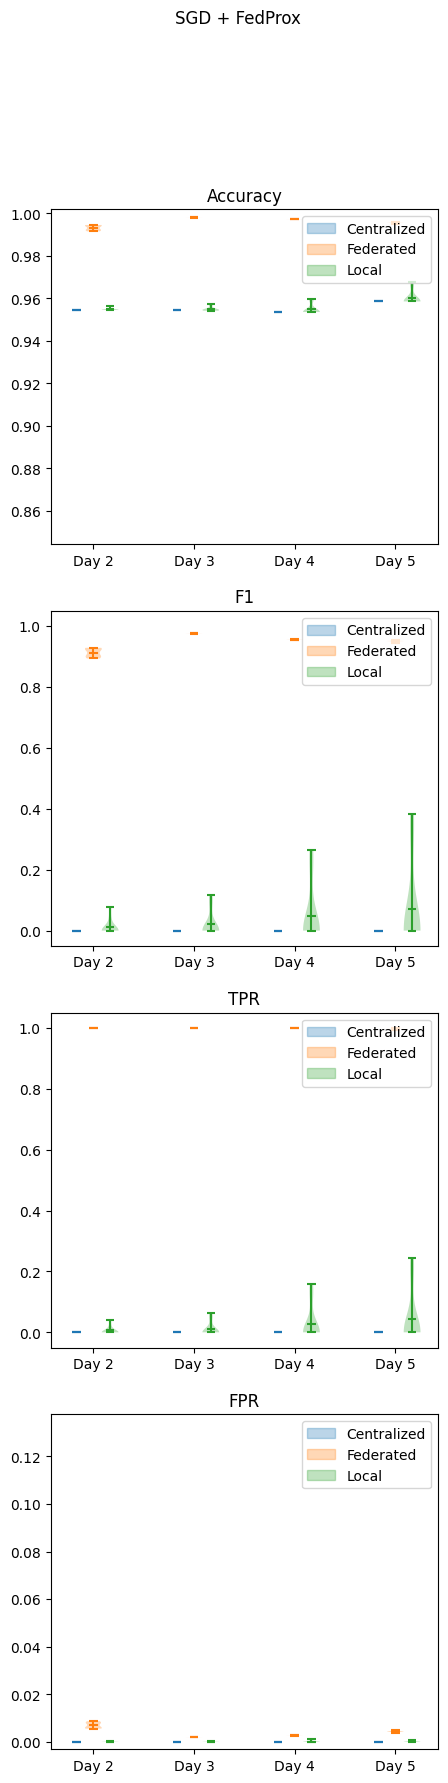

In [73]:
plot_result(results['experiment_exp_sup_v1_False_optimizer_sgd_fedprox'], 'SGD + FedProx')

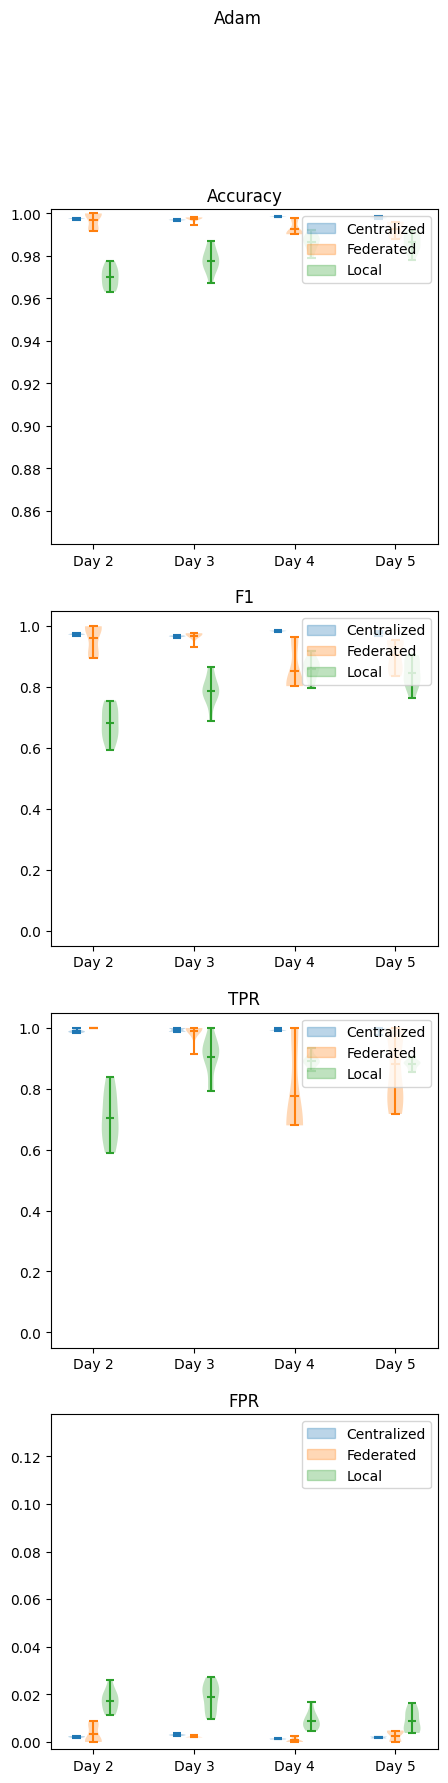

In [74]:
plot_result(results['experiment_exp_sup_v1_False_optimizer_adam'], 'Adam')

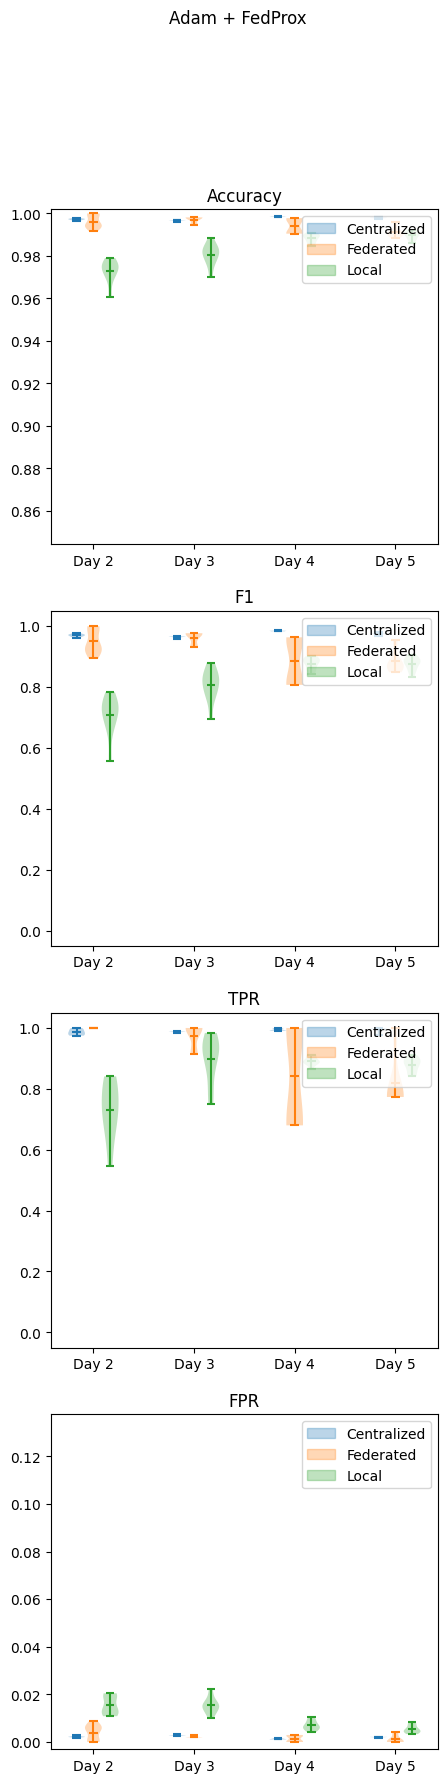

In [75]:
plot_result(results['experiment_exp_sup_v1_False'], 'Adam + FedProx')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


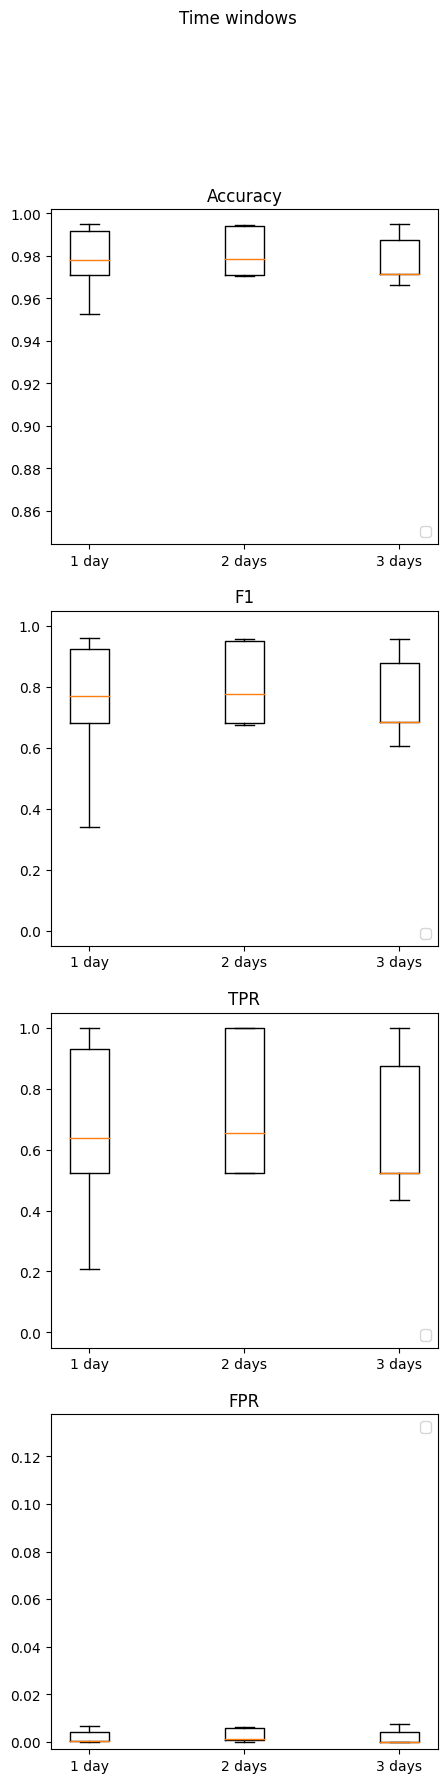

In [74]:
def _plot_result(res, axs, metric, metric_name, label_names):
    labels = []

    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))
        
    n = len(res)
    # for i, (metrics, label) in enumerate(zip(res, label_names)):
    #     dataset = metrics.fed_runs[-1][metric]
    #     #print(len(dataset), len([(n-1) * (i) - 1/n] * len(dataset)))

    box = axs.boxplot(
        x=[r.fed_runs[-1][metric].values for r in res], 
        vert=True,
        labels=label_names,
        positions=[(n-1) * (i) - 1/n for i in range(n)],
    )
    legend_loc = 4 if metric != 'fpr' else 1
    #axs.legend(*zip(*labels), loc=legend_loc)
    axs.legend(loc=legend_loc)
    #axs.set_xticks([3 * i for i in range(res[0].n_days)], [f'Day {i + 2}' for i in range(3, 4)])
    axs.set_title(metric_name)

    return


def plot_optimizers(res, title, labels, ylims=ylims):
    fig, axs = plt.subplots(4, 1, figsize=(5, 20))
    fig.set_tight_layout(False)
    _plot_result(res, axs[0], 'acc', 'Accuracy', labels)
    _plot_result(res, axs[1], 'f1', 'F1', labels)
    _plot_result(res, axs[2], 'tpr', 'TPR', labels)
    _plot_result(res, axs[3], 'fpr', 'FPR', labels)

    # new_ylims = []
    # for ax, (y_max, y_min) in zip(axs, ylims):
    #     ax_min, ax_max = ax.get_ylim()
    #     new_ylims.append([max(y_max, ax_max), min(y_min, ax_min)])
    # ylims = new_ylims
    for ax, (y_max, y_min) in zip(axs, ylims):
        ax.set_ylim((y_min, y_max))

    fig.suptitle(title)
    plt.show()

plot_optimizers(
    [
        results['experiment_exp_sup_v1_True_v2_True_1800s_scenario'],
        results['experiment_exp_sup_v1_True_v2_True_1800s_2d_scenario'],
        results['experiment_exp_sup_v1_True_v2_True_1800s_3d_scenario'],
    ], 
    'Time windows', 
    ['1 day', '2 days', '3 days']
)

In [68]:
res =    [
        results['experiment_exp_sup_v1_True_v2_True_1800s_scenario'],
        results['experiment_exp_sup_v1_True_v2_True_1800s_2d_scenario'],
        results['experiment_exp_sup_v1_True_v2_True_1800s_3d_scenario'],
    ]
import numpy as np
[r.fed_runs[-1]['acc'] for r in res][0].values.shape
#[res.fed_runs[day]['fpr'] for day in range(3, 4)], [res.fed_runs[-1]['fpr']]

(10,)

In [109]:
complete = CompleteResult.from_fed(experiments_dir/'experiment_exp_sup_v1_False_mu_01/results/00/day1_890542409_federated_results.pckl')

In [110]:
complete.val_loss

0     1.294137
1     1.278820
2     0.558922
3     0.543944
4     0.493647
        ...   
70    0.110566
71    0.109966
72    0.109463
73    0.109076
74    0.109905
Name: val_loss, Length: 75, dtype: float64

## Complete supervised experiment table

In [12]:

def format_metric(val, std, decimals=2):
    val *= 100
    std *= 100
    return  f'${val:.{decimals}f} \pm {std:.{decimals}f}$'

multihead_res = results['experiment_exp_sup_v1_False']
cls_res = results['experiment_exp_sup_v1_True']

experiemts_res = [
    ('S1 Multihead Model', results['experiment_exp_sup_v1_False']),
    ('S1 Classifier Only Model', results['experiment_exp_sup_v1_True']),
    ('S2 Multihead Model', results['experiment_exp_sup_v1_False_v3_False']),
    ('S2 Classifier Only Model', results['experiment_exp_sup_v1_True_v3_False']),
    ('S3 Multihead Model', results['experiment_exp_sup_v1_False_v2_False']),
    ('S3 Classifier Only Model', results['experiment_exp_sup_v1_True_v2_False']),

        ('S4 Multihead Model', results['experiment_exp_sup_v1_False_v2_True_v4_scenario']),
    ('S4 Classifier Only Model', results['experiment_exp_sup_v1_True_v2_True_v4_scenario']),
    ('S3+S4 Multihead Model', results['experiment_exp_sup_v1_False_v2_False_v4_scenario']),
    ('S3+S4 Classifier Only Model', results['experiment_exp_sup_v1_True_v2_False_v4_scenario']),
]

model_results = {}
for model_name, model_res in experiemts_res:
    metric_dfs = {}
    for metric_name, metric in [('Acc', 'acc'), ('TPR', 'tpr'), ('FPR', 'fpr'), ('F1', 'f1')]:
        day_dics = defaultdict(lambda: defaultdict(dict))
        for i, day_res in enumerate(model_res.days, start=2):
            for exp_name, res in (('Cent.', day_res.cent), ('Fed.', day_res.fed), ('Local', day_res.local)):
                day_dics[f'Day {i}'][exp_name][f'${metric_name} \pm std$'] = format_metric(res.data[metric].iloc[0], res.data[f'{metric}_std'].iloc[0])


        metric_dfs[metric_name] = pd.concat({key: pd.DataFrame(value) for key, value in day_dics.items()}, axis=1)

    model_df = pd.concat(metric_dfs, axis=0)
    model_df.index = model_df.index.droplevel()
    model_results[model_name] = model_df

df = pd.concat(model_results, axis=0)

table = df.style.to_latex(
    column_format='rr|ccc|ccc|ccc|ccc',
    multirow_align='c',
    multicol_align='c',
    hrules=True,
    label='tab:exp-sup',
    caption='',
).replace('\\textbackslash ', '\\')\
    .replace('\\$', '$')\
    .replace('\\multirow[c]', '\\midrule\n\\multirow[c]')

with open('table-sup-complete', 'w') as f:
    f.write(table)

In [139]:

def format_metric(val, std, decimals=2):
    val *= 100
    std *= 100
    return  f'${val:.{decimals}f} \pm {std:.{decimals}f}$'

multihead_res = results['experiment_exp_sup_v1_False']
cls_res = results['experiment_exp_sup_v1_True']

experiemts_res = [
    ('S4 Multihead Model', results['experiment_exp_sup_v1_False_v2_True_v4_scenario']),
    ('S4 Classifier Only Model', results['experiment_exp_sup_v1_True_v2_True_v4_scenario']),
    ('S3+S4 Multihead Model', results['experiment_exp_sup_v1_False_v2_False_v4_scenario']),
    ('S3+S4 Classifier Only Model', results['experiment_exp_sup_v1_True_v2_False_v4_scenario']),
]

model_results = {}
for model_name, model_res in experiemts_res:
    metric_dfs = {}
    for metric_name, metric in [('Acc', 'acc'), ('TPR', 'tpr'), ('FPR', 'fpr'), ('F1', 'f1')]:
        day_dics = defaultdict(lambda: defaultdict(dict))
        for i, day_res in enumerate(model_res.days, start=2):
            for exp_name, res in (('Cent.', day_res.cent), ('Fed.', day_res.fed), ('Local', day_res.local)):
                day_dics[f'Day {i}'][exp_name][f'${metric_name} \pm std$'] = format_metric(res.data[metric].iloc[0], res.data[f'{metric}_std'].iloc[0])


        metric_dfs[metric_name] = pd.concat({key: pd.DataFrame(value) for key, value in day_dics.items()}, axis=1)

    model_df = pd.concat(metric_dfs, axis=0)
    model_df.index = model_df.index.droplevel()
    model_results[model_name] = model_df

df = pd.concat(model_results, axis=0)


print(df.style.to_latex(
    column_format='rr|ccc|ccc|ccc|ccc',
    multirow_align='c',
    multicol_align='c',
    hrules=True,
    label='tab:exp-sup-scenario',
    caption='',
)
      .replace('\\textbackslash ', '\\')
      .replace('\\$', '$')
      .replace('\\multirow[c]', '\\midrule\n\\multirow[c]')
      )

\begin{table}
\label{tab:exp-sup-scenario}
\begin{tabular}{rr|ccc|ccc|ccc|ccc}
\toprule
 &  & \multicolumn{3}{c}{Day 2} & \multicolumn{3}{c}{Day 3} & \multicolumn{3}{c}{Day 4} & \multicolumn{3}{c}{Day 5} \\
 &  & Cent. & Fed. & Local & Cent. & Fed. & Local & Cent. & Fed. & Local & Cent. & Fed. & Local \\
\midrule
\midrule
\multirow[c]{4}{*}{S4 Multihead Model} & $Acc \pm std$ & $99.99 \pm 0.02$ & $99.01 \pm 0.45$ & $99.18 \pm 0.23$ & $99.50 \pm 0.22$ & $99.39 \pm 0.36$ & $98.23 \pm 0.37$ & $100.00 \pm 0.01$ & $99.26 \pm 0.33$ & $99.27 \pm 0.24$ & $99.78 \pm 0.02$ & $99.47 \pm 0.16$ & $98.96 \pm 0.18$ \\
 & $TPR \pm std$ & $100.00 \pm 0.00$ & $17.92 \pm 33.21$ & $100.00 \pm 0.00$ & $93.96 \pm 15.35$ & $86.15 \pm 12.07$ & $79.49 \pm 14.26$ & $100.00 \pm 0.00$ & $77.60 \pm 15.46$ & $93.25 \pm 6.99$ & $100.00 \pm 0.00$ & $96.56 \pm 6.98$ & $83.88 \pm 1.98$ \\
 & $FPR \pm std$ & $0.01 \pm 0.02$ & $0.06 \pm 0.18$ & $0.83 \pm 0.24$ & $0.38 \pm 0.16$ & $0.20 \pm 0.02$ & $1.36 \pm 0.42$ & $0.00

## Summary supervised experiment table

In [148]:

def format_metric(val, std, decimals=2):
    val *= 100
    std *= 100
    return  f'${val:.{decimals}f} \pm {std:.{decimals}f}$'

multihead_res = results['experiment_exp_sup_v1_False']
cls_res = results['experiment_exp_sup_v1_True']

experiemts_res = [
    ('S1 Multihead Model', results['experiment_exp_sup_v1_False']),
    ('S1 Classifier Only Model', results['experiment_exp_sup_v1_True']),
    ('S2 Multihead Model', results['experiment_exp_sup_v1_False_v3_False']),
    ('S2 Classifier Only Model', results['experiment_exp_sup_v1_True_v3_False']),
    ('S3 Multihead Model', results['experiment_exp_sup_v1_False_v2_False']),
    ('S3 Classifier Only Model', results['experiment_exp_sup_v1_True_v2_False']),
]

model_results = {}
for model_name, model_res in experiemts_res:
    metric_dfs = {}
    for metric_name, metric in [('Acc', 'acc'), ('TPR', 'tpr'), ('FPR', 'fpr'), ('F1', 'f1')]:
        day_dics = defaultdict(lambda: defaultdict(dict))
        for exp_name, res in (('Cent.', model_res.cent_runs), ('Fed.', model_res.fed_runs), ('Local', model_res.local_runs)):
            summary_metric = pd.concat([r[metric] for r in res])
            day_dics[exp_name][f'${metric_name} \pm std$'] = format_metric(summary_metric.mean(), summary_metric.std())

        metric_dfs[metric_name] = pd.DataFrame(day_dics)

    model_df = pd.concat(metric_dfs, axis=0)
    model_df.index = model_df.index.droplevel()
    model_results[model_name] = model_df

df = pd.concat(model_results, axis=0)

with open('table-sup-summary.txt', 'w') as f:
    table = df.style.to_latex(
        column_format='rr|ccc',
        multirow_align='c',
        multicol_align='c',
        hrules=True,
        label='tab:exp-sup-summary',
        caption='',
    ).replace('\\textbackslash ', '\\')\
        .replace('\\$', '$')\
        .replace('\\multirow[c]', '\\midrule\n\\multirow[c]')
    f.write(table)

df

Cent.               Fed.  \
S1 Multihead Model       $Acc \pm std$  $99.76 \pm 0.07$   $99.61 \pm 0.17$   
                         $TPR \pm std$  $99.10 \pm 0.81$   $99.78 \pm 1.37$   
                         $FPR \pm std$   $0.21 \pm 0.06$    $0.39 \pm 0.18$   
                         $F1 \pm std$   $97.37 \pm 0.78$   $94.96 \pm 2.13$   
S1 Classifier Only Model $Acc \pm std$  $99.77 \pm 0.07$   $99.62 \pm 0.16$   
                         $TPR \pm std$  $99.05 \pm 0.71$   $99.77 \pm 1.37$   
                         $FPR \pm std$   $0.20 \pm 0.06$    $0.38 \pm 0.17$   
                         $F1 \pm std$   $97.44 \pm 0.75$   $95.06 \pm 1.98$   
S2 Multihead Model       $Acc \pm std$  $99.78 \pm 0.08$   $99.62 \pm 0.15$   
                         $TPR \pm std$  $99.73 \pm 0.54$  $100.00 \pm 0.00$   
                         $FPR \pm std$   $0.22 \pm 0.08$    $0.40 \pm 0.15$   
                         $F1 \pm std$   $97.57 \pm 0.78$   $95.03 \pm 1.72$   
S2 Classifier Only Model $Acc \pm std$  $99.79 \pm 0.08$   $99.61 \pm 0.16$   
                         $TPR \pm std$  $99.70 \pm 0.53$   $99.92 \pm 0.49$   
                         $FPR \pm std$   $0.21 \pm 0.07$    $0.40 \pm 0.17$   
                         $F1 \pm std$   $97.67 \pm 0.83$   $94.98 \pm 1.97$   
S3 Multihead Model       $Acc \pm std$  $99.76 \pm 0.06$   $99.60 \pm 0.21$   
                         $TPR \pm std$  $99.42 \pm 0.71$  $100.00 \pm 0.00$   
                         $FPR \pm std$   $0.22 \pm 0.06$    $0.41 \pm 0.22$   
                         $F1 \pm std$   $97.37 \pm 0.61$   $94.85 \pm 2.60$   
S3 Classifier Only Model $Acc \pm std$  $99.77 \pm 0.06$   $99.19 \pm 1.10$   
                         $TPR \pm std$  $99.32 \pm 0.73$  $87.50 \pm 33.49$   
                         $FPR \pm std$   $0.21 \pm 0.05$    $0.38 \pm 0.25$   
                         $F1 \pm std$   $97.41 \pm 0.65$  $82.79 \pm 31.78$   

                                                    Local  
S1 Multihead Model       $Acc \pm std$   $98.29 \pm 0.78$  
                         $TPR \pm std$   $84.94 \pm 9.23$  
                         $FPR \pm std$    $1.08 \pm 0.55$  
                         $F1 \pm std$    $81.72 \pm 8.13$  
S1 Classifier Only Model $Acc \pm std$   $98.11 \pm 0.81$  
                         $TPR \pm std$   $83.02 \pm 9.89$  
                         $FPR \pm std$    $1.19 \pm 0.59$  
                         $F1 \pm std$    $79.76 \pm 8.41$  
S2 Multihead Model       $Acc \pm std$   $98.08 \pm 1.28$  
                         $TPR \pm std$   $90.72 \pm 8.58$  
                         $FPR \pm std$    $1.56 \pm 1.10$  
                         $F1 \pm std$   $81.66 \pm 11.05$  
S2 Classifier Only Model $Acc \pm std$   $98.37 \pm 0.97$  
                         $TPR \pm std$   $91.76 \pm 8.40$  
                         $FPR \pm std$    $1.31 \pm 0.76$  
                         $F1 \pm std$    $83.81 \pm 9.12$  
S3 Multihead Model       $Acc \pm std$   $97.60 \pm 0.47$  
                         $TPR \pm std$  $64.87 \pm 11.15$  
                         $FPR \pm std$    $0.88 \pm 0.57$  
                         $F1 \pm std$    $70.39 \pm 5.86$  
S3 Classifier Only Model $Acc \pm std$   $97.67 \pm 0.54$  
                         $TPR \pm std$  $64.40 \pm 13.78$  
                         $FPR \pm std$    $0.79 \pm 0.64$  
                         $F1 \pm std$    $70.60 \pm 7.13$

In [37]:
def format_metric(val, std, decimals=2):
    val *= 100
    std *= 100
    return  f'${val:.{decimals}f} \pm {std:.{decimals}f}$'

multihead_res = results['experiment_exp_sup_v1_False']
cls_res = results['experiment_exp_sup_v1_True']
# ad_res = results['experiment_exp_ad_v1_True']

experiemts_res = [
    ('mh', results['experiment_exp_sup_v1_False']),
    ('cls', results['experiment_exp_sup_v1_True']),
    ('ad', results['experiment_exp_ad_v1_True_v2_10']),
    ('mh-s3', results['experiment_exp_sup_v1_False_v3_False']),
    ('cls-s3', results['experiment_exp_sup_v1_True_v3_False']),
    ('mh-s3-s4', results['experiment_exp_sup_v1_False_v2_False_v4_scenario']),
    ('cls-s3-s4', results['experiment_exp_sup_v1_True_v2_False_v4_scenario']),
    ('mh-s4', results['experiment_exp_sup_v1_False_v2_True_v4_scenario']),
    ('cls-s4', results['experiment_exp_sup_v1_True_v2_True_v4_scenario']),
    # ('S2 Multihead Model', results['experiment_exp_sup_v1_False_v3_False']),
    # ('S2 Classifier Only Model', results['experiment_exp_sup_v1_True_v3_False']),
    # ('S3 Multihead Model', results['experiment_exp_sup_v1_False_v2_False']),
    # ('S3 Classifier Only Model', results['experiment_exp_sup_v1_True_v2_False']),
]

model_results = {}
for model_name, model_res in experiemts_res:
    metric_dfs = {}
    for metric_name, metric in [('Acc', 'acc'), ('TPR', 'tpr'), ('FPR', 'fpr'), ('F1', 'f1')]:
        day_dics = defaultdict(lambda: defaultdict(dict))
        for exp_name, res in [('Fed.', model_res.fed_runs)]:
            summary_metric = pd.concat([r[metric] for r in res[1:4]])
            day_dics[exp_name][f'{metric_name}'] = summary_metric

        metric_dfs[metric_name] = pd.DataFrame(day_dics)

    model_df = pd.concat(metric_dfs, axis=0)
    model_df.index = model_df.index.droplevel()
    model_results[model_name] = model_df

df = pd.concat(model_results, axis=0)
from scipy.stats import ttest_ind
a = df.loc['mh-s3-s4', 'TPR'][ 'Fed.'].values
b = df.loc['cls-s3-s4', 'TPR']['Fed.'].values

c = df.loc['mh-s4', 'TPR'][ 'Fed.'].values
d = df.loc['cls-s4', 'TPR']['Fed.'].values
display((a == 0).mean() * 100)
display((b == 0).mean() * 100)

display((c == 0).mean() * 100)
display((d == 0).mean() * 100)
display(a.mean(), b.mean())
display(a.std(), b.std())
ttest_ind(a, b, equal_var=False)

3.3333333333333335

3.3333333333333335

0.0

0.0

0.8734384757344508

0.8396272133273482

0.2070238450147119

0.20823049930221751

Ttest_indResult(statistic=0.6200966210543164, pvalue=0.5376230650072142)

In [147]:

def format_metric(val, std, decimals=2):
    val *= 100
    std *= 100
    return f'${val:.{decimals}f} \pm {std:.{decimals}f}$'


multihead_res = results['experiment_exp_sup_v1_False']
cls_res = results['experiment_exp_sup_v1_True']

experiemts_res = [
    ('A1', results['experiment_exp_ad_v1_True_v2_10']),
    ('A2:', results['experiment_exp_ad_v1_False_v2_10']),
    ('A3: 6 clients', results['experiment_exp_ad_v1_True_v2_6']),
    ('A3: 3 clients', results['experiment_exp_ad_v1_True_v2_3']),
]

model_results = {}
for model_name, model_res in experiemts_res:
    metric_dfs = {}
    for metric_name, metric in [('Acc', 'acc'), ('TPR', 'tpr'), ('FPR', 'fpr'), ('F1', 'f1')]:
        day_dics = defaultdict(lambda: defaultdict(dict))
        for exp_name, res in (
        ('Cent.', model_res.cent_runs), ('Fed.', model_res.fed_runs), ('Local', model_res.local_runs)):
            summary_metric = pd.concat([r[metric] for r in res])
            day_dics[exp_name][f'${metric_name} \pm std$'] = format_metric(summary_metric.mean(), summary_metric.std())

        metric_dfs[metric_name] = pd.DataFrame(day_dics)

    model_df = pd.concat(metric_dfs, axis=0)
    model_df.index = model_df.index.droplevel()
    model_results[model_name] = model_df

df = pd.concat(model_results, axis=0)
with open('table_ad-summary.txt', 'w') as f:
    table = df.style.to_latex(
        column_format='rr|ccc',
        multirow_align='c',
        multicol_align='c',
        hrules=True,
        label='tab:exp-ad-summary',
        caption='',
    ).replace('\\textbackslash ', '\\')\
        .replace('\\$', '$')\
        .replace('\\multirow[c]', '\\midrule\n\\multirow[c]')
    f.write(table)

df

Cent.              Fed.  \
A1            $Acc \pm std$  $96.65 \pm 0.31$  $96.03 \pm 0.47$   
              $TPR \pm std$  $46.14 \pm 2.24$  $45.46 \pm 0.89$   
              $FPR \pm std$   $1.00 \pm 0.31$   $1.66 \pm 0.45$   
              $F1 \pm std$   $55.14 \pm 2.49$  $50.09 \pm 2.83$   
A2:           $Acc \pm std$  $96.65 \pm 0.32$  $96.07 \pm 0.43$   
              $TPR \pm std$  $46.12 \pm 2.25$  $45.29 \pm 0.60$   
              $FPR \pm std$   $0.99 \pm 0.32$   $1.61 \pm 0.43$   
              $F1 \pm std$   $55.18 \pm 2.53$  $50.22 \pm 2.60$   
A3: 6 clients $Acc \pm std$  $96.58 \pm 0.40$  $94.78 \pm 1.10$   
              $TPR \pm std$  $46.11 \pm 2.21$  $45.52 \pm 0.61$   
              $FPR \pm std$   $1.06 \pm 0.44$   $2.98 \pm 1.09$   
              $F1 \pm std$   $54.71 \pm 2.94$  $43.70 \pm 4.41$   
A3: 3 clients $Acc \pm std$  $96.31 \pm 0.68$  $94.16 \pm 1.13$   
              $TPR \pm std$  $46.05 \pm 2.14$  $45.35 \pm 0.59$   
              $FPR \pm std$   $1.34 \pm 0.68$   $3.62 \pm 1.14$   
              $F1 \pm std$   $53.01 \pm 4.28$  $40.82 \pm 4.25$   

                                        Local  
A1            $Acc \pm std$  $95.24 \pm 0.66$  
              $TPR \pm std$  $45.12 \pm 0.70$  
              $FPR \pm std$   $2.46 \pm 0.68$  
              $F1 \pm std$   $45.56 \pm 3.31$  
A2:           $Acc \pm std$  $95.60 \pm 0.67$  
              $TPR \pm std$  $45.29 \pm 0.71$  
              $FPR \pm std$   $2.09 \pm 0.71$  
              $F1 \pm std$   $47.63 \pm 3.28$  
A3: 6 clients $Acc \pm std$  $94.97 \pm 0.82$  
              $TPR \pm std$  $45.32 \pm 0.69$  
              $FPR \pm std$   $2.76 \pm 0.80$  
              $F1 \pm std$   $44.35 \pm 3.37$  
A3: 3 clients $Acc \pm std$  $93.37 \pm 2.13$  
              $TPR \pm std$  $44.91 \pm 0.37$  
              $FPR \pm std$   $4.42 \pm 2.14$  
              $F1 \pm std$   $38.57 \pm 6.66$

In [143]:


def format_metric(val, std, decimals=2):
    val *= 100
    std *= 100
    return  f'${val:.{decimals}f} \pm {std:.{decimals}f}$'

ad_res = results['experiment_exp_ad_v1_True_v2_10']
ad_results = {
    'ad-a1': results['experiment_exp_ad_v1_True_v2_10'],
    'ad-a2': results['experiment_exp_ad_v1_False_v2_10'],
    'ad-a3-6': results['experiment_exp_ad_v1_True_v2_6'],
    'ad-a3-3': results['experiment_exp_ad_v1_True_v2_3']
}
ad_appendix_tables = ''

for label, ad_res in ad_results.items():

    metric_dfs = {}
    for metric_name, metric in [('Acc', 'acc'), ('TPR', 'tpr'), ('FPR', 'fpr'), ('F1', 'f1')]:
        day_dics = defaultdict(lambda: defaultdict(dict))
        for i, day_res in enumerate(ad_res.days, start=2):
            for exp_name, res in (('Cent.', day_res.cent), ('Fed.', day_res.fed), ('Local', day_res.local)):
                day_dics[f'Day {i}'][exp_name][f'${metric_name} \pm std$'] = format_metric(res.data[metric].iloc[0], res.data[f'{metric}_std'].iloc[0])

        metric_dfs[metric_name] = pd.concat({key: pd.DataFrame(value) for key, value in day_dics.items()}, axis=0)

    model_df = pd.concat(metric_dfs, axis=0)
    model_df.index = model_df.index.droplevel()
    index, order = model_df.index.sortlevel(0)
    model_df = model_df.iloc[order]

    with open(f'table_{label}.txt', 'w') as f:
        table = model_df.style.to_latex(
            column_format='rr|ccc',
            multirow_align='c',
            multicol_align='c',
            hrules=True,
            label=f'tab:exp-{label}',
            caption=''
        )\
            .replace('\\textbackslash ', '\\')\
            .replace('\\$', '$')\
            .replace('\\multirow[c]', '\\midrule\n\\multirow[c]')
        f.write(table)
        ad_appendix_tables += table
with open('AD_appendix_tables', 'w') as f:
    f.write(ad_appendix_tables)

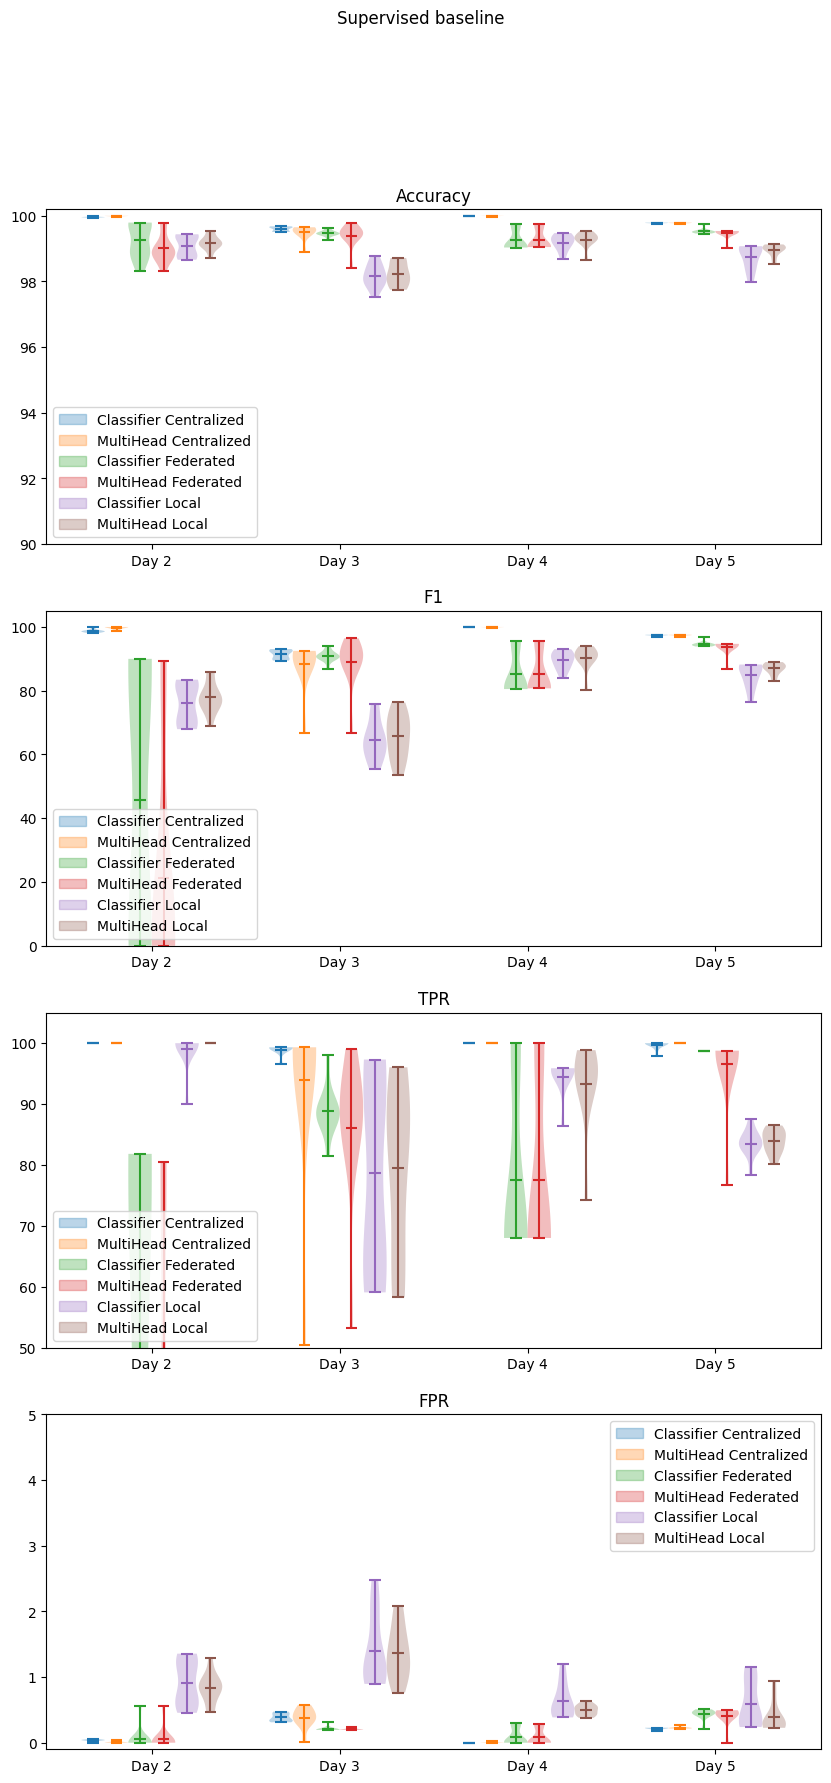

In [184]:
def _plot_result(res_cl, res_mh, axs, metric, metric_name):
    labels = []

    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    add_label(axs.violinplot(dataset=[res_cl.cent_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                             positions=[4 * (i) - 1.25 for i in range(4)]), 'Classifier Centralized')
    add_label(axs.violinplot(dataset=[res_mh.cent_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                         positions=[4 * (i) - 0.75 for i in range(4)]), 'MultiHead Centralized')
    add_label(axs.violinplot(dataset=[res_cl.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                             positions=[4 * i - 0.25 for i in range(4)]), 'Classifier Federated')
    add_label(axs.violinplot(dataset=[res_mh.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                         positions=[4 * i + 0.25 for i in range(4)]), 'MultiHead Federated')
    add_label(axs.violinplot(dataset=[res_cl.local_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                             positions=[4 * i + 0.75 for i in range(4)]), 'Classifier Local')
    add_label(axs.violinplot(dataset=[res_mh.local_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                         positions=[4 * i + 1.25 for i in range(4)]), 'MultiHead Local')
    legend_loc = 3 if metric != 'fpr' else 1
    axs.legend(*zip(*labels), loc=legend_loc)
    axs.set_xticks([4 * i for i in range(4)], [f'Day {i + 2}' for i in range(4)])
    axs.set_title(metric_name)

    return


def plot_cl_vs_multihead(res_cl, res_mh, title, ylims=ylims):
    fig, axs = plt.subplots(4, 1, figsize=(10, 20))
    fig.set_tight_layout(False)
    _plot_result(res_cl, res_mh, axs[0], 'acc', 'Accuracy')
    _plot_result(res_cl, res_mh, axs[1], 'f1', 'F1')
    _plot_result(res_cl, res_mh, axs[2], 'tpr', 'TPR')
    _plot_result(res_cl, res_mh, axs[3], 'fpr', 'FPR')

    # new_ylims = []
    # for ax, (y_max, y_min) in zip(axs, ylims):
    #     ax_min, ax_max = ax.get_ylim()
    #     new_ylims.append([max(y_max, ax_max), min(y_min, ax_min)])
    # ylims = new_ylims
    for ax, (y_max, y_min) in zip(axs, ylims):
        ax.set_ylim((y_min, y_max))

    fig.suptitle(title)
    plt.show()

plot_cl_vs_multihead(results['experiment_exp_sup_v1_True_v2_True_v4_scenario'], results['experiment_exp_sup_v1_False_v2_True_v4_scenario'], "Supervised baseline", [[100.2, 90], [105, 0], [105, 50], [5, -0.1]])

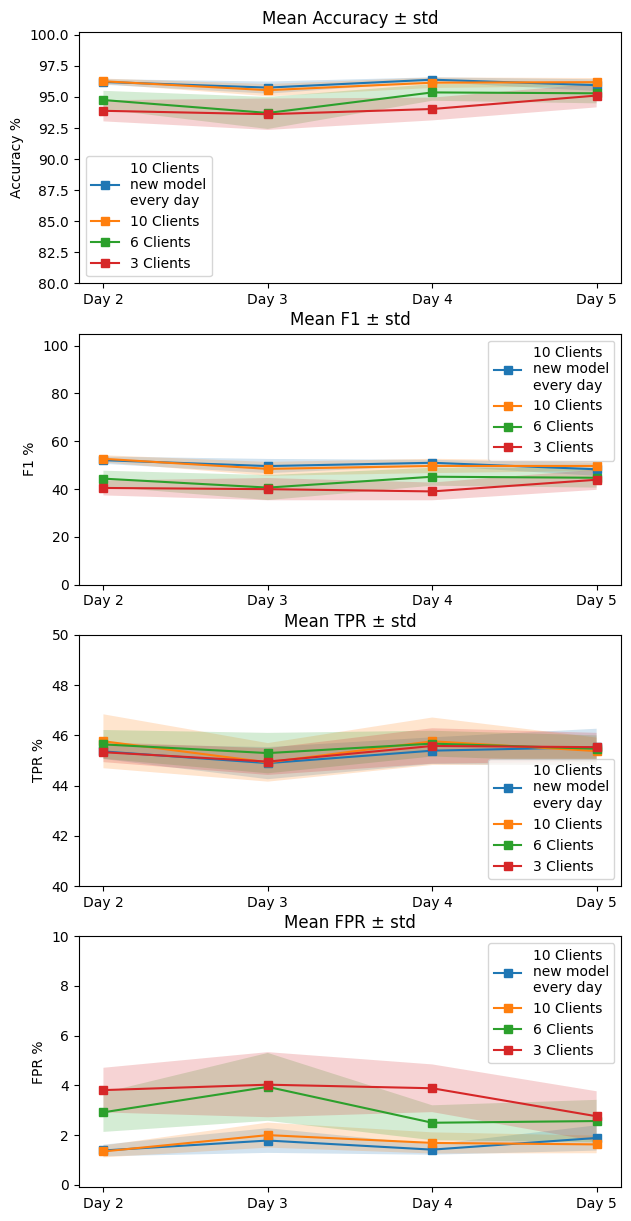

In [24]:
def _plot_result(res, name, axs, metric, metric_name):

    mean = res.fed_df[f'{metric}_mean'] * 100
    std = res.fed_df[f'{metric}_std'] * 100
    axs.plot(range(4), mean, marker='s', label=name)
    axs.fill_between(range(4), mean - std, mean + std, alpha=0.2)

    legend_loc = 3 if metric != 'fpr' else 1
    axs.set_xticks(range(4), [f'Day {i + 2}' for i in range(4)])
    axs.set_title(f'Mean {metric_name} ± std')

    #axs.set_xlabel('Testing Day')
    axs.set_ylabel(f'{metric_name} %')

    return axs


def plot_ad(results, title, ylims=ylims):
    fig, axs = plt.subplots(4, 1, figsize=(7, 15))
    fig.set_tight_layout(False)
    for i, res in results.items():
        _plot_result(res, i, axs[0], 'acc', 'Accuracy')
        _plot_result(res, i, axs[1], 'f1', 'F1')
        _plot_result(res, i, axs[2], 'tpr', 'TPR')
        _plot_result(res, i, axs[3], 'fpr', 'FPR')

    # new_ylims = []
    # for ax, (y_max, y_min) in zip(axs, ylims):
    #     ax_min, ax_max = ax.get_ylim()
    #     new_ylims.append([max(y_max, ax_max), min(y_min, ax_min)])
    # ylims = new_ylims
    for ax, (y_max, y_min) in zip(axs, ylims):
        ax.legend()
        ax.set_ylim((y_min, y_max))

    #fig.suptitle(title)
    plt.show()

results_ad = {
    '10 Clients\nnew model\nevery day': results['experiment_exp_ad_v1_False_v2_10'],
    '10 Clients': results['experiment_exp_ad_v1_True_v2_10'],
    '6 Clients': results['experiment_exp_ad_v1_True_v2_6'],
    '3 Clients': results['experiment_exp_ad_v1_True_v2_3']
   }
plot_ad(results_ad, "Anomaly Detection", [[100.2, 80], [105, 0], [50, 40], [10, -0.1]])

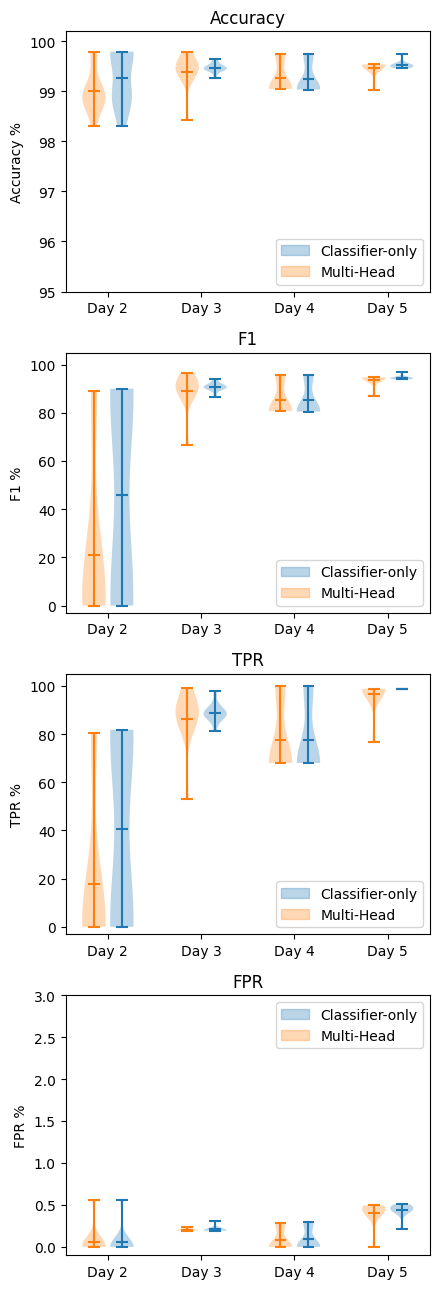

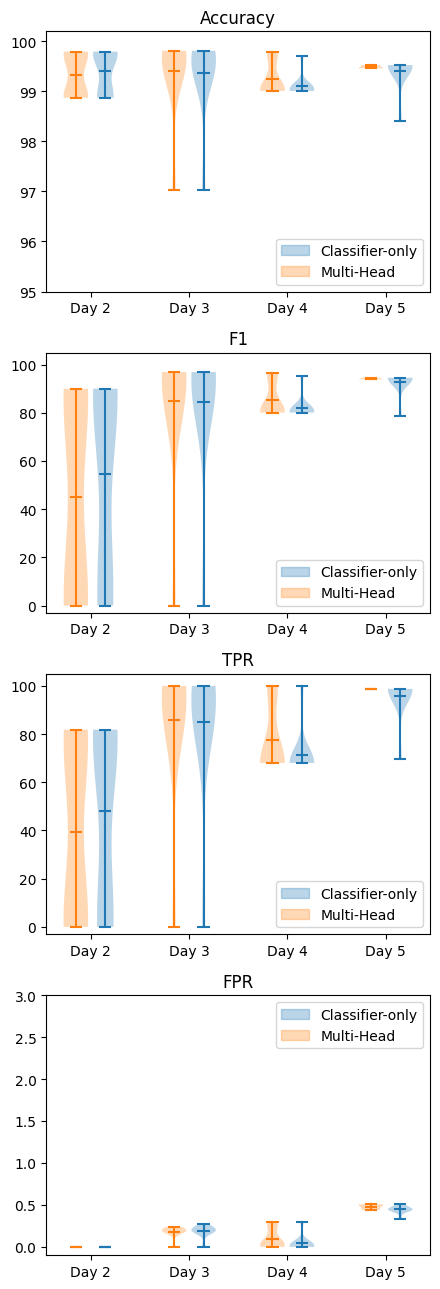

In [50]:
def _plot_result(s4_cl, s4_mh, s3_s4_cl, s3_s4_mh, ax, ax_2, metric, metric_name):
    labels = []

    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    add_label(ax.violinplot(dataset=[s4_cl.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i + 0.3  for i in range(4)]), 'Classifier-only')
    add_label(ax.violinplot(dataset=[s4_mh.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i - 0.3 for i in range(4)]), 'Multi-Head')
    ax_2.violinplot(dataset=[s3_s4_cl.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i + 0.3 for i in range(4)])
    ax_2.violinplot(dataset=[s3_s4_mh.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i - 0.3 for i in range(4)])
    legend_loc = 4 if metric != 'fpr' else 1
    ax.legend(*zip(*labels), loc=legend_loc)
    ax_2.legend(*zip(*labels), loc=legend_loc)
    ax.set_xticks([2 * i for i in range(4)], [f'Day {i + 2}' for i in range(4)])
    ax_2.set_xticks([2 * i for i in range(4)], [f'Day {i + 2}' for i in range(4)])
    ax.set_title(metric_name)
    ax_2.set_title(metric_name)
    ax.set_ylabel(f'{metric_name} %')
    #ax_2.set_yticks([])
    #axs.set_xlabel('Testing day')

    return


def plot_cl_vs_multihead(s4_cl, s4_mh, s3_s4_cl, s3_s4_mh, title, ylims=ylims):
    fig, axs = plt.subplots(4, 1, figsize=(4.5, 13))
    fig_2, axs_2 = plt.subplots(4, 1, figsize=(4.5, 13))
    fig.set_tight_layout(False)
    _plot_result(s4_cl, s4_mh, s3_s4_cl, s3_s4_mh, axs[0], axs_2[0], 'acc', 'Accuracy')
    _plot_result(s4_cl, s4_mh, s3_s4_cl, s3_s4_mh, axs[1], axs_2[1], 'f1', 'F1')
    _plot_result(s4_cl, s4_mh, s3_s4_cl, s3_s4_mh, axs[2], axs_2[2], 'tpr', 'TPR')
    _plot_result(s4_cl, s4_mh, s3_s4_cl, s3_s4_mh, axs[3], axs_2[3], 'fpr', 'FPR')

    # new_ylims = []
    # for ax, (y_max, y_min) in zip(axs, ylims):
    #     ax_min, ax_max = ax.get_ylim()
    #     new_ylims.append([max(y_max, ax_max), min(y_min, ax_min)])
    # ylims = new_ylims
    for ax, ax_2, (y_max, y_min) in zip(axs, axs_2, ylims):
        ax.set_ylim((y_min, y_max))
        ax_2.set_ylim((y_min, y_max))

    fig.tight_layout()
    fig_2.tight_layout()

    #fig.suptitle(title)
    fig.savefig('exp_sup_s4.pdf')
    fig_2.savefig('exp_sup_s3+s4.pdf')
    plt.show()

plot_cl_vs_multihead(
    results['experiment_exp_sup_v1_True_v2_True_v4_scenario'],
    results['experiment_exp_sup_v1_False_v2_True_v4_scenario'],
    results['experiment_exp_sup_v1_True_v2_False_v4_scenario'],
    results['experiment_exp_sup_v1_False_v2_False_v4_scenario'],
    "Federated results on scenario S4", [[100.2, 95], [105, -3], [105, -3], [3, -0.1]])

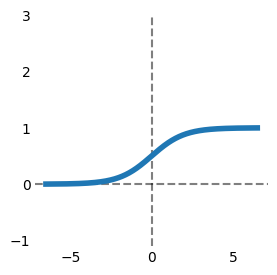

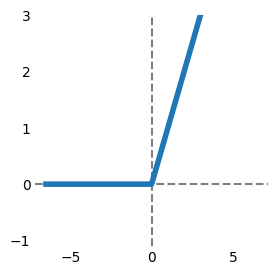

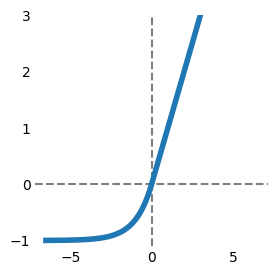

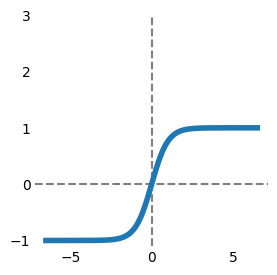

In [7]:
import numpy as np
sigmoid = lambda x: 1 / (1 + np.exp(-x))
relu = lambda x: np.max([np.zeros_like(x), x], axis=0)
elu = lambda x: np.hstack([np.exp(x[x<0]) - 1, x[x>0]])
tanh = lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))


x = np.linspace(-6.5, 6.5, 1000)

for name, fun in [('Sigmoid', sigmoid), ('ReLu', relu), ('ELU', elu), ('Tanh', tanh)]:
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(y=0, color='k', alpha=0.5, linestyle='--')
    ax.axvline(x=0, color='k', alpha=0.5, linestyle='--')
    ax.set_ylim((-1.1, 3))
    #ax.set_yticks([])
    #ax.set_xticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.tick_params(axis=u'both', which=u'both',length=0)

    plt.plot(x, fun(x), linewidth=4)
    plt.savefig(f'activation_{name}.pdf')

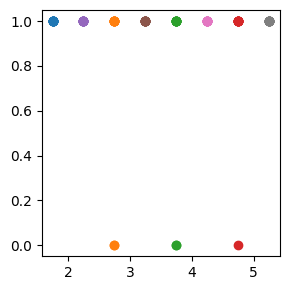

In [19]:


# def _plot_result(s4_cl, s4_mh, s3_s4_cl, s3_s4_mh, axs, metric, metric_name):
#     labels = []
#
#     def add_label(violin, label):
#         color = violin["bodies"][0].get_facecolor().flatten()
#         labels.append((mpatches.Patch(color=color), label))
#
#     add_label(axs.violinplot(dataset=[s4_cl.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
#                              positions=[3 * i - 0.75 for i in range(4)]), 'S4\nClassifier Only')
#     add_label(axs.violinplot(dataset=[s4_mh.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
#                              positions=[3 * i - 0.25 for i in range(4)]), 'S4\nMultiHead')
#     add_label(axs.violinplot(dataset=[s3_s4_cl.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
#                              positions=[3 * i + 0.25 for i in range(4)]), 'S3+S4\nClassifier Only')
#     add_label(axs.violinplot(dataset=[s3_s4_mh.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
#                              positions=[3 * i + 0.75 for i in range(4)]), 'S3+S4\nMultiHead')
#     legend_loc = 4 if metric != 'fpr' else 1
#     axs.legend(*zip(*labels), loc=legend_loc)
#     axs.set_xticks([3 * i for i in range(4)], [f'Day {i + 2}' for i in range(4)])
#     axs.set_title(metric_name)
#
#     axs.set_ylabel(f'{metric_name} %')
#     #axs.set_xlabel('Testing day')
#
#     return


def plot_cl_vs_multihead(s3_cl, s3_mh, title, ylims=ylims):
    fig, ax = plt.subplots(figsize=(3, 3))
    fig.set_tight_layout(True)

    for i, day in enumerate(s3_cl.fed_runs, start=2):
        ax.scatter([i-0.25] * 10, day['tpr'], label='Classifier-only model')

    for i, day in enumerate(s3_mh.fed_runs, start=2):
        ax.scatter([i+0.25] * 10, day['tpr'], label='Multi-Head model')


    # new_ylims = []
    # for ax, (y_max, y_min) in zip(axs, ylims):
    #     ax_min, ax_max = ax.get_ylim()
    #     new_ylims.append([max(y_max, ax_max), min(y_min, ax_min)])
    # ylims = new_ylims

    fig.tight_layout()
    #fig.suptitle(title)
    plt.savefig('exp_sup_scenario.pdf')
    plt.show()


plot_cl_vs_multihead(
    results['experiment_exp_sup_v1_True_v2_False'],
    results['experiment_exp_sup_v1_False_v2_False'],
    "Federated results on scenario S4", [[100.2, 95], [105, -3], [105, -3], [3, -0.1]])

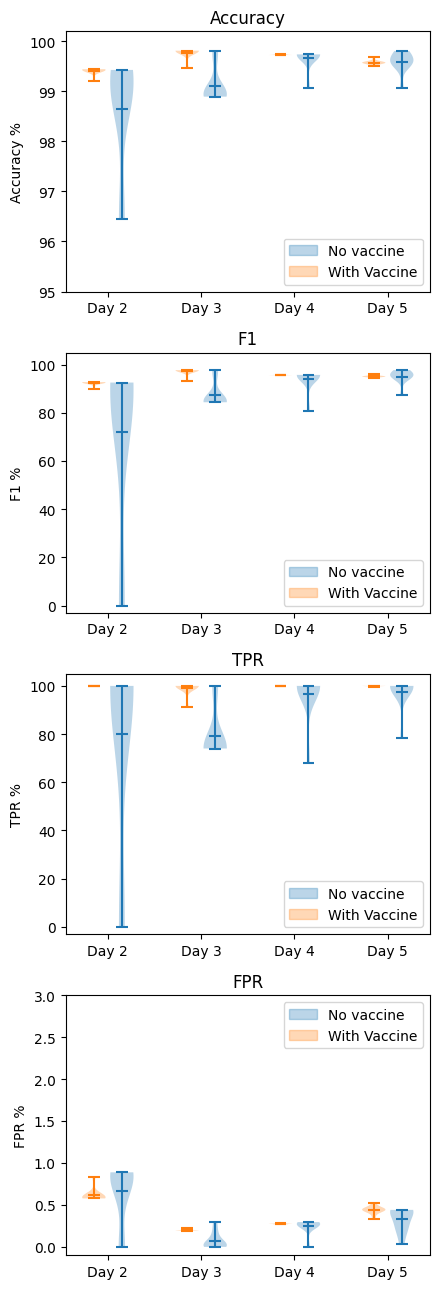

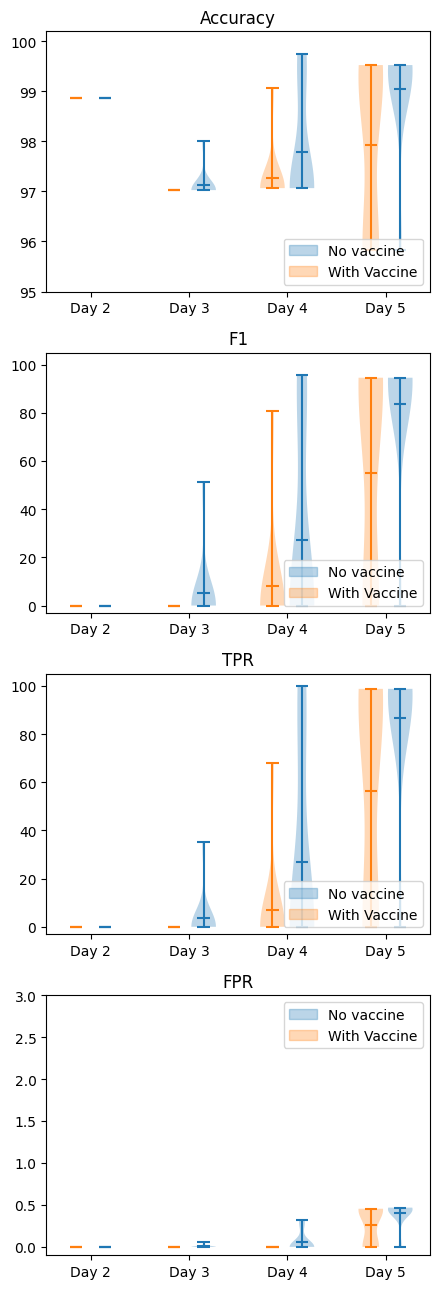

In [62]:
def _plot_result(s1_nv, s1, s3_s4_cl, s3_s4_mh, ax, ax_2, metric, metric_name):
    labels = []

    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))

    add_label(ax.violinplot(dataset=[s1_nv.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i + 0.3  for i in range(4)]), 'No vaccine')
    add_label(ax.violinplot(dataset=[s1.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i - 0.3 for i in range(4)]), 'With Vaccine')
    ax_2.violinplot(dataset=[s3_s4_cl.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i + 0.3 for i in range(4)])
    ax_2.violinplot(dataset=[s3_s4_mh.fed_runs[day][metric] * 100 for day in range(4)], showmeans=True,
                            positions=[2 * i - 0.3 for i in range(4)])
    legend_loc = 4 if metric != 'fpr' else 1
    ax.legend(*zip(*labels), loc=legend_loc)
    ax_2.legend(*zip(*labels), loc=legend_loc)
    ax.set_xticks([2 * i for i in range(4)], [f'Day {i + 2}' for i in range(4)])
    ax_2.set_xticks([2 * i for i in range(4)], [f'Day {i + 2}' for i in range(4)])
    ax.set_title(metric_name)
    ax_2.set_title(metric_name)
    ax.set_ylabel(f'{metric_name} %')
    #ax_2.set_yticks([])
    #axs.set_xlabel('Testing day')

    return


def plot_cl_vs_multihead(s1_nv, s1, s3_s4_cl, s3_s4_mh, title, ylims=ylims):
    fig, axs = plt.subplots(4, 1, figsize=(4.5, 13))
    fig_2, axs_2 = plt.subplots(4, 1, figsize=(4.5, 13))
    fig.set_tight_layout(False)
    _plot_result(s1_nv, s1, s3_s4_cl, s3_s4_mh, axs[0], axs_2[0], 'acc', 'Accuracy')
    _plot_result(s1_nv, s1, s3_s4_cl, s3_s4_mh, axs[1], axs_2[1], 'f1', 'F1')
    _plot_result(s1_nv, s1, s3_s4_cl, s3_s4_mh, axs[2], axs_2[2], 'tpr', 'TPR')
    _plot_result(s1_nv, s1, s3_s4_cl, s3_s4_mh, axs[3], axs_2[3], 'fpr', 'FPR')

    # new_ylims = []
    # for ax, (y_max, y_min) in zip(axs, ylims):
    #     ax_min, ax_max = ax.get_ylim()
    #     new_ylims.append([max(y_max, ax_max), min(y_min, ax_min)])
    # ylims = new_ylims
    for ax, ax_2, (y_max, y_min) in zip(axs, axs_2, ylims):
        ax.set_ylim((y_min, y_max))
        ax_2.set_ylim((y_min, y_max))

    fig.tight_layout()
    fig_2.tight_layout()

    #fig.suptitle(title)
    fig.savefig('exp_sup_s4.pdf')
    fig_2.savefig('exp_sup_s3+s4.pdf')
    plt.show()

plot_cl_vs_multihead(
    results['experiment_exp_sup_v1_True_no_vaccine'],
    results['experiment_exp_sup_v1_True'],
    results['experiment_exp_sup_v1_True_v2_True_v4_scenario_no_vaccine'],
    results['experiment_exp_sup_v1_False_v2_True_v4_scenario_no_vaccine'],
    "Federated results on scenario S4", [[100.2, 95], [105, -3], [105, -3], [3, -0.1]])

In [90]:
ad_cent, ad_fed, ad_local = [], [], []
metric = 'acc'
for exp, res in results.items():
    if 'exp_ad' not in exp:
        continue
    ad_cent += list(res.cent_df[metric].values)
    ad_fed += list(res.fed_df[metric].values)
    ad_local += list(res.local_df[metric].values)

ad_cent, ad_fed, ad_local = np.array(ad_cent), np.array(ad_fed), np.array(ad_local)

In [91]:
ad_cent.mean(), ad_fed.mean(), ad_local.mean()

(0.9654779152776103, 0.9525982403927766, 0.9479631924233122)

In [87]:
ad_cent.std(), ad_fed.std(), ad_local.std()

(0.0026749741026928023, 0.00949422411966676, 0.012427307937378182)

In [80]:
sup_cent, sup_fed, sup_local = [], [], []
metric = 'acc'
for exp, res in results.items():
    if 'exp_sup' not in exp: #or 'v4_scenario' in exp:
        continue
    sup_cent += list(res.cent_df[metric].values)
    sup_fed += list(res.fed_df[metric].values)
    sup_local += list(res.local_df[metric].values)

sup_cent, sup_fed, sup_local = np.array(sup_cent), np.array(sup_fed), np.array(sup_local)

In [81]:
sup_cent.mean(), sup_fed.mean(), sup_local.mean()

(0.9979832649670604, 0.9946090102119267, 0.9826767948690183)

In [82]:
sup_cent.std(), sup_fed.std(), sup_local.std()

(0.00120019662930528, 0.00211777115876792, 0.0075053007755801005)